In [1]:
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Task 1 : Visualize the images and create the atlases

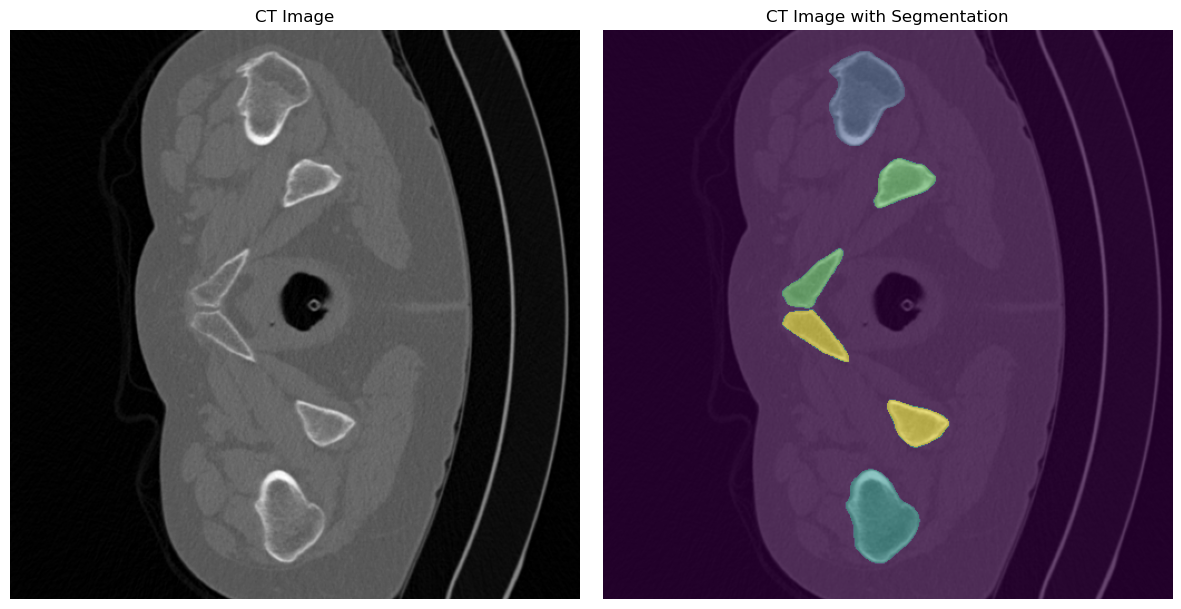

In [2]:
# Path to the NIfTI files
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
# ct_image_path = r"Dataset\GROUP_images\g1_54_image.nii"

ct_image = nib.load(ct_image_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

def visualize_slice_and_mask(ct_image, mask, slice_idx):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.imshow(mask[:, :, slice_idx], alpha=0.5)
    plt.title("CT Image with Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


slice_idx = ct_image.shape[2] // 2 -100
visualize_slice_and_mask(ct_image, mask, slice_idx)


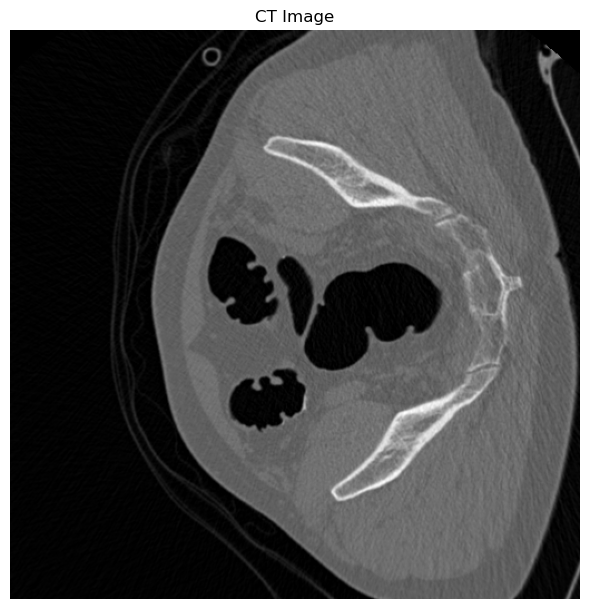

In [3]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\GROUP_images\g1_55_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2
visualize_slice(ct_image,slice_idx)

# There is two types of dataset :

* First one : COMMON => 3 patients/CT scans that are already segmented => We have to segment the left femur and hip bones

* Second one : GROUP => We can take groupe 1 files = 3 patients/CT scans : they are not segmented at all, we have to do the segmentation manually

In [5]:
import os

common_dir = r"Dataset\COMMON_images_masks" 
output_dir = r"Dataset\Output_mask"  

os.makedirs(output_dir, exist_ok=True)


LEFT_FEMUR = 2  
LEFT_HIP_BONE = 4  
RIGHT_HIP_BONE = 3

mask_files = [f for f in os.listdir(common_dir) if "_mask.nii" in f]

# Processus de segmentation
for mask_file in mask_files:
    print(f"Traitement du fichier {mask_file}...")
    
    
    mask_path = os.path.join(common_dir, mask_file)
    mask_nii = nib.load(mask_path)
    mask_data = mask_nii.get_fdata()
    
    
    new_mask = np.zeros_like(mask_data)
    new_mask[mask_data == LEFT_FEMUR] = 1  
    new_mask[mask_data == LEFT_HIP_BONE] = 2 
    new_mask[mask_data == RIGHT_HIP_BONE] = 3
    
    # Enregistrer le nouveau masque
    new_mask_nii = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
    output_path = os.path.join(output_dir, f"filtered_{mask_file}")
    nib.save(new_mask_nii, output_path)
    print(f"Masque filtré enregistré : {output_path}")


Traitement du fichier common_40_mask.nii...


KeyboardInterrupt: 

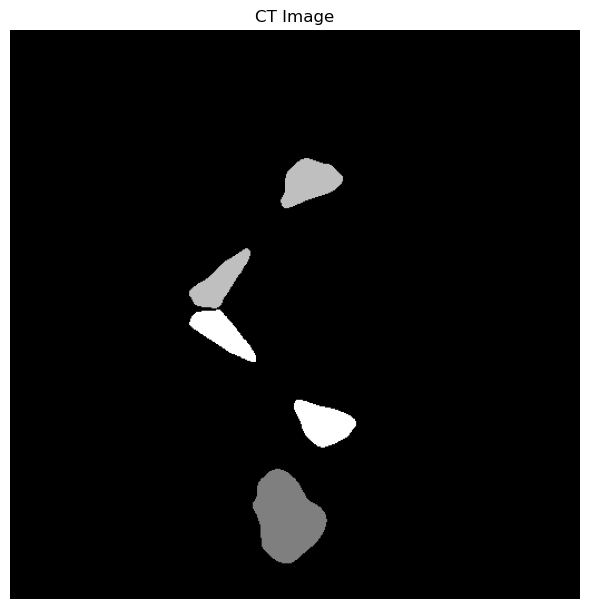

NameError: name 'visualize_slice_and_mask' is not defined

In [2]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\Output_mask\filtered_common_40_mask.nii.gz" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2 -100
visualize_slice(ct_image,slice_idx)
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
mask = nib.load(mask_path).get_fdata()
visualize_slice_and_mask(ct_image, mask, slice_idx)

# Task 2: Create the functions for registration (other file)

# Task 3: Atlas-based segmentation

In [2]:
import Codes.Registration as reg

In [3]:
# Helper functions

def numpy_to_sitk(mask_array, reference_image):
    """
    Convert a binary Numpy mask to a SimpleITK image.
    
    Parameters:
    - mask_array: The Numpy array representing the mask (binary).
    - reference_image: A SimpleITK image that defines the geometry of the mask
    
    Returns:
    - SimpleITK mask image
    """
    # Ensure the mask is binary (0 or 1)
    mask_array = np.round(mask_array).astype(np.uint8)
    
    # Convert the Numpy array to a SimpleITK image
    mask_sitk = sitk.GetImageFromArray(mask_array)
    
    # Set the spatial properties (spacing, origin, direction) to match the reference image
    mask_sitk.SetSpacing(reference_image.GetSpacing())
    mask_sitk.SetOrigin(reference_image.GetOrigin())
    mask_sitk.SetDirection(reference_image.GetDirection())
    
    return mask_sitk

def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## a) Registration of the group images on the common_40 

In [4]:
# Load the images
ref_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii"
ref_image = sitk.ReadImage(ref_image_path,sitk.sitkFloat32)
x,y,_ = ref_image.GetOrigin()
ref_image.SetOrigin([x,y,0])

moving_image_paths = [r"Dataset/GROUP_images/g1_53_image.nii",
                      r"Dataset/GROUP_images/g1_54_image.nii",
                      r"Dataset/GROUP_images/g1_55_image.nii"]
moving_images = []
for moving_image_path in moving_image_paths:
    moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
    x,y,_ = moving_image.GetOrigin()
    moving_image.SetOrigin([x,y,0])
    moving_images.append(moving_image)

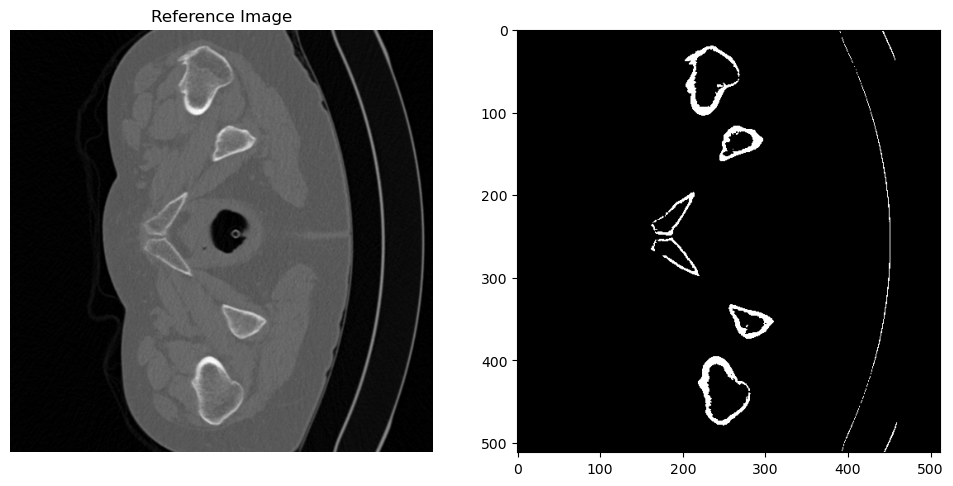

In [5]:
# Create the bone mask for the reference image
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
mask = np.logical_and(ref_array>300,ref_array<3000) # Hounsfield values for bones : 300-3000
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(ref_array[:, :, ref_array.shape[2]//2 - 100], cmap="gray")
plt.title("Reference Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mask[:, :, ref_array.shape[2]//2 - 100], cmap="gray")

sitk_mask = numpy_to_sitk(mask.swapaxes(0,2), ref_image)

In [6]:
# Find the transformations for the moving images, for now, only linear transformations
transformations = []
for i,moving_image in enumerate(moving_images):
    print(f"Aligning image g1_{i+53}...")
    moving_image = sitk.Resample(moving_image, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_image.GetPixelID()) # Resample the moving image to match the reference image
    transformation = reg.est_lin_transf(ref_image, moving_image, sitk_mask, verbose = True)
    transformations.append(transformation)

Aligning image g1_53...
--------
Affine registration:
Final metric value: 454248.59088228527
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 34.
Number of iterations: 34
--------
Aligning image g1_54...
--------
Affine registration:
Final metric value: 299224.78773276124
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 57.
Number of iterations: 57
--------
Aligning image g1_55...
--------
Affine registration:
Final metric value: 372768.40339254995
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 41.
Number of iterations: 41
--------


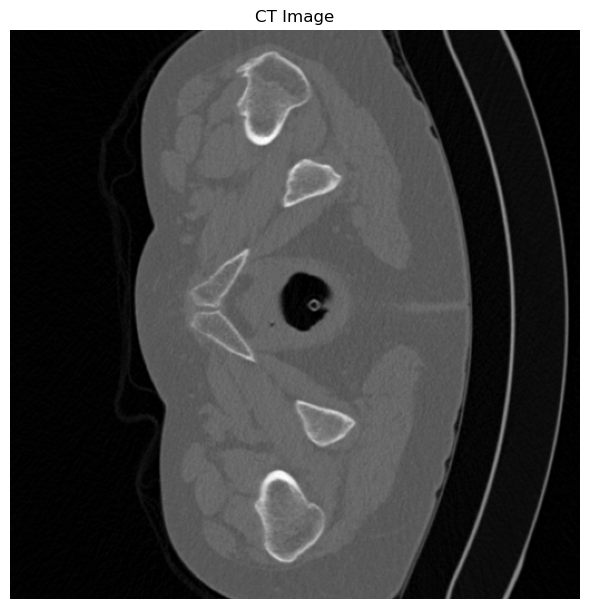

Plotting transformed image g1_53...


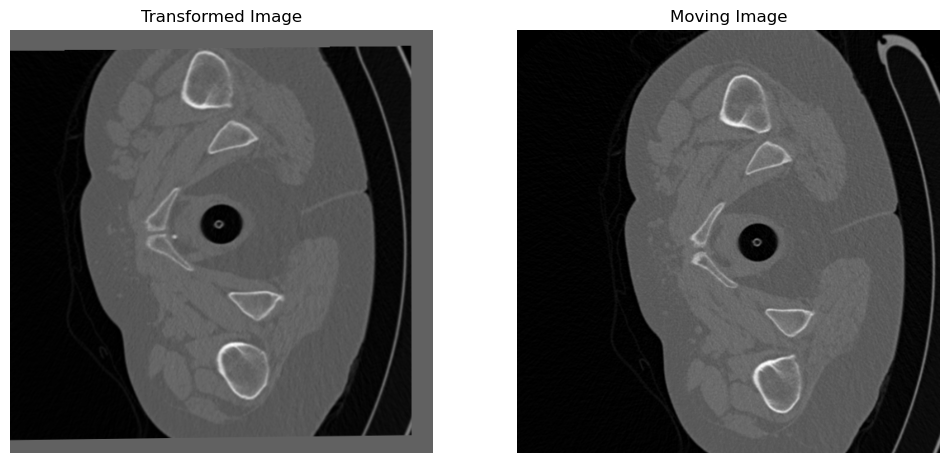

Plotting transformed image g1_54...


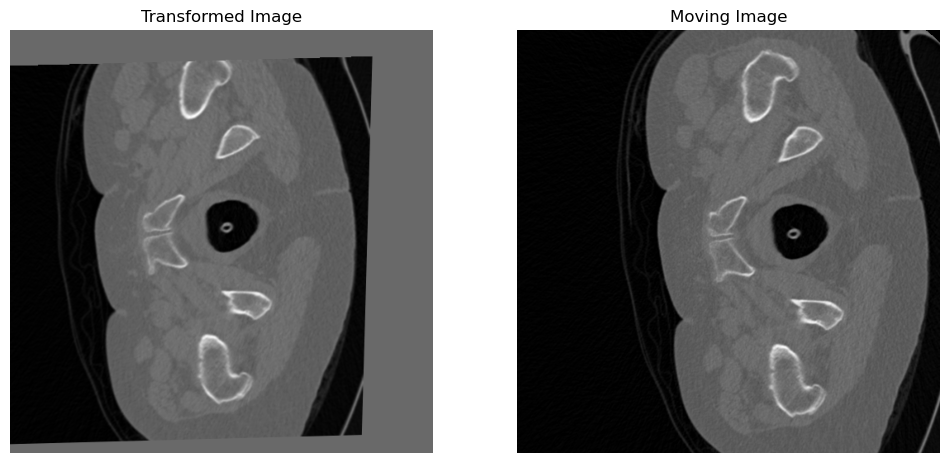

Plotting transformed image g1_55...


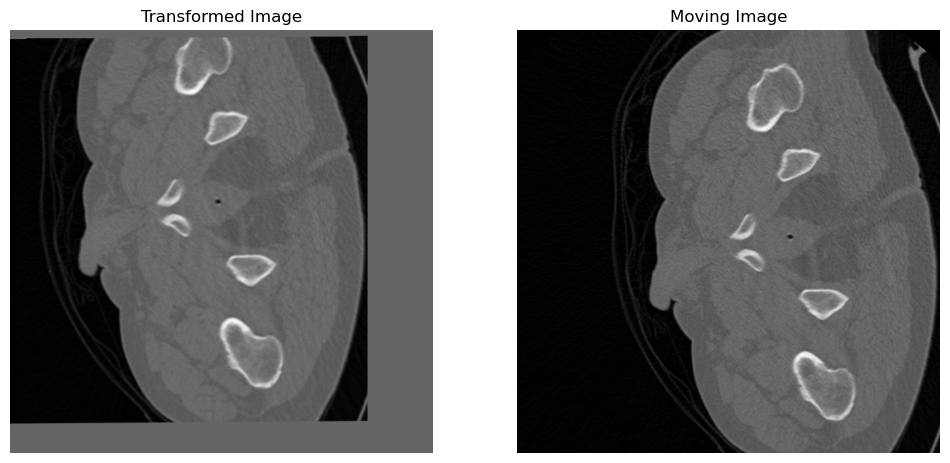

In [7]:
# Plot the transformations to check the results
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
slice = ref_array.shape[2] // 2-100
visualize_slice(ref_array, slice)
for i, transformation in enumerate(transformations):
    print(f"Plotting transformed image g1_{i+53}...")
    transformed_image = sitk.Resample(moving_images[i], ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_images[i].GetPixelID())
    transformed_image = reg.apply_lin_transf(transformed_image, transformation)
    transformed_array = sitk.GetArrayFromImage(transformed_image)
    transformed_array = transformed_array.swapaxes(0, 2)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(transformed_array[:, :, slice], cmap="gray")
    plt.title("Transformed Image")
    plt.axis("off")
    moving_array = sitk.GetArrayFromImage(moving_images[i])
    moving_array = moving_array.swapaxes(0, 2)
    plt.subplot(1, 2, 2)
    plt.imshow(moving_array[:, :, slice], cmap="gray")
    plt.title("Moving Image")
    plt.axis("off")
    plt.show()

In [8]:
transformations[0].GetParameters()

(1.0253020068603014,
 0.012775025243265944,
 0.029842581832534354,
 -0.001198552890588321,
 1.0002828088972913,
 0.008970871134365923,
 -0.0045496304928121095,
 0.002243599017900949,
 0.9946970668396864,
 -8.396265608348386,
 0.8144527549850576,
 3.928623509718373)

## b) Transform the masks and do a majority voting for segmentation

In [9]:
# Helper functions

def convert_mask_to_sitk(mask, reference_image):
    """
    Convert a mask loaded with nibabel into a SimpleITK image.
    
    Parameters:
    - mask_filename: Path to the mask file (e.g., .nii or .nii.gz)
    - reference_image: A SimpleITK image that defines the geometry of the mask
    
    Returns:
    - SimpleITK mask image
    """
    # Ensure that the mask is binary (0 or 1)
    mask = np.round(mask).astype(np.uint8)
    print(np.unique(mask))
    
    # Convert the Numpy array to a SimpleITK image
    mask_sitk = sitk.GetImageFromArray(mask)
    
    # Match the SimpleITK image's spacing and origin to the reference image
    mask_sitk.SetSpacing(reference_image.GetSpacing())
    mask_sitk.SetOrigin(reference_image.GetOrigin())
    mask_sitk.SetDirection(reference_image.GetDirection())
    
    return mask_sitk

In [10]:
# Load the masks
mask_paths = [r"Dataset\GROUP_images\g1_53_merged_masks.nii.gz",
                r"Dataset\GROUP_images\g1_54_merged_masks.nii.gz",
                r"Dataset\GROUP_images\g1_55_merged_masks.nii.gz"]
masks = []
for i,mask_path in enumerate(mask_paths):
    mask = nib.load(mask_path).get_fdata()
    mask = mask.swapaxes(0, 2)
    mask = convert_mask_to_sitk(mask, moving_images[i])
    masks.append(mask)

[  0 254 255]
[  0 254 255]
[  0 254 255]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


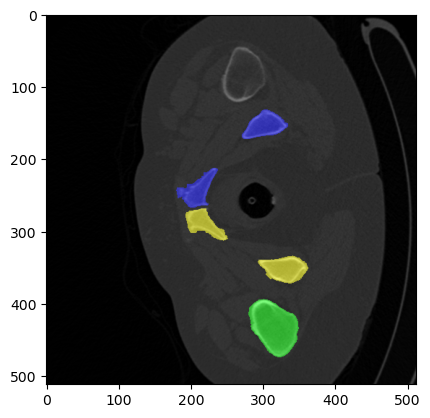

In [11]:
mask = nib.load(mask_paths[0]).get_fdata()
moving_array = sitk.GetArrayFromImage(moving_images[0])
moving_array = moving_array.swapaxes(0, 2)
plt.imshow(moving_array[:, :, moving_array.shape[2] // 2-100], cmap="gray")
plt.imshow(mask[:,:,mask.shape[2]//2-100], alpha=0.5)

In [12]:
# Apply the transformations to the masks
transformed_masks = []
for i,mask in enumerate(masks):
    print(f"Transforming mask g1_{i+53} with size {mask.GetSize()}...")
    mask =  sitk.Resample(mask, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, mask.GetPixelID())
    print(mask.GetSize())
    transformed_mask = reg.apply_lin_transf(mask, transformations[i])
    transformed_masks.append(transformed_mask)

Transforming mask g1_53 with size (512, 512, 311)...
(512, 512, 286)
Transforming mask g1_54 with size (512, 512, 276)...
(512, 512, 286)
Transforming mask g1_55 with size (512, 512, 301)...
(512, 512, 286)


(512, 512, 286, 3)


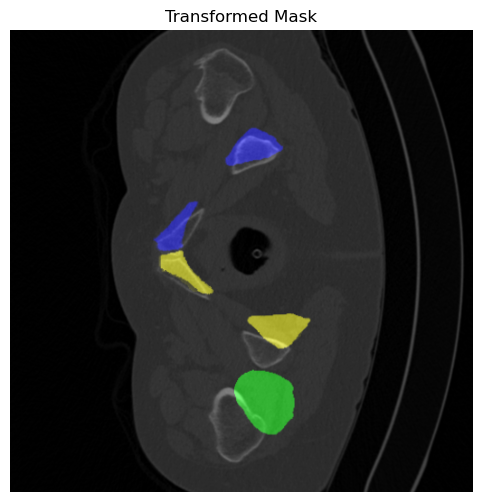

(512, 512, 286, 3)


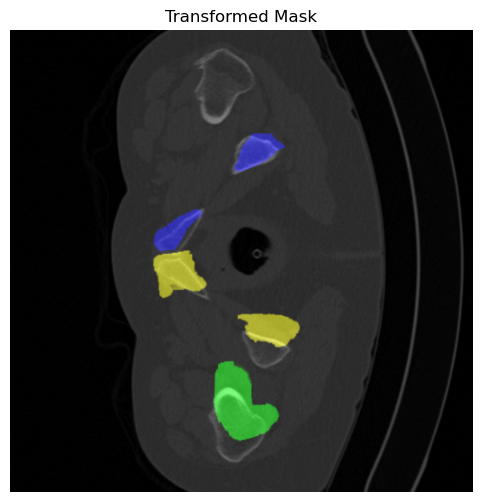

(512, 512, 286, 3)


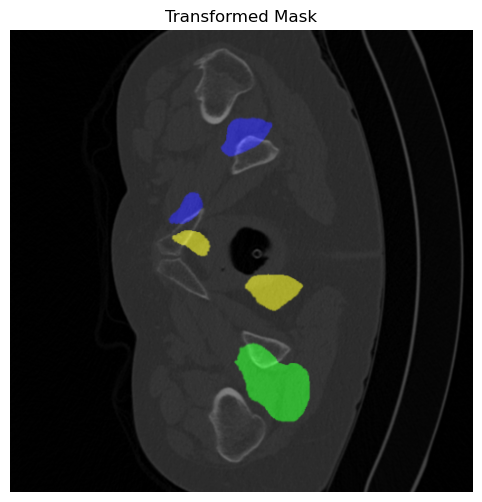

In [13]:
# Print the 3 masks to check the results
for i,t_mask in enumerate(transformed_masks):
    t_mask_array = sitk.GetArrayFromImage(t_mask)
    t_mask_array = t_mask_array.swapaxes(0, 2)
    print(t_mask_array.shape)
    plt.figure(figsize=(12, 6))
    plt.imshow(ref_array[:, :, ref_array.shape[2] // 2-100], cmap="gray")
    plt.imshow(t_mask_array[:, :, ref_array.shape[2] // 2-100], alpha=0.5)
    plt.title("Transformed Mask")
    plt.axis("off")
    plt.show()

In [14]:
# Majority voting and save the results
final_masks = []
final_mask_y = np.zeros_like(ref_array)
final_mask_g = np.zeros_like(ref_array)
final_mask_b = np.zeros_like(ref_array)
for i,t_mask in enumerate(transformed_masks):
    print(f"Processing mask g1_{i+53} of shape {t_mask.GetSize()}...")
    t_mask_array = sitk.GetArrayFromImage(t_mask)
    t_mask_array = t_mask_array.swapaxes(0, 2)
    t_mask_array = np.where(t_mask_array==254, 255, t_mask_array)
    t_mask_array = np.where(t_mask_array!=255, 0, t_mask_array)
    final_mask_y += (t_mask_array == np.array([255,255,0])).all(axis= 3)
    final_mask_g += (t_mask_array == np.array([0,255,0])).all(axis= 3)
    final_mask_b += (t_mask_array == np.array([0,0,255])).all(axis= 3)

final_mask_y = np.where(final_mask_y>1, 3, 0)
final_mask_g = np.where(final_mask_g>1, 2, 0)
final_mask_b = np.where(final_mask_b>1, 1, 0)
final_mask = final_mask_y + final_mask_g + final_mask_b
final_masks.append(final_mask)

Processing mask g1_53 of shape (512, 512, 286)...
Processing mask g1_54 of shape (512, 512, 286)...
Processing mask g1_55 of shape (512, 512, 286)...


In [15]:
np.unique(final_mask)

array([0, 1, 2, 3])

## c) Do the same for common_41 and common_42

In [ ]:
# Do task 3.a and 3.b in one function

In [ ]:
# Apply the function to common_41 and common_42

# Task 4: Accuracy assessment

# Task 5: Image classification